# Практика 7: Использование GAN для генерации противоречивых примеров

**Выполнил студент 2 курса группы: ББМО-02-23**

**ФИО: Козлов Филипп Сергеевич**

In [1]:
# Импорт необходимых библиотек
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, LeakyReLU, Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt

print('Библиотеки успешно импортированы.')

Библиотеки успешно импортированы.


In [2]:
# Загрузка и подготовка данных MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train / 127.5) - 1.0  # Нормализация данных в диапазон [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)

print(f'Данные загружены: {x_train.shape}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Данные загружены: (60000, 28, 28, 1)


In [3]:
# Реализация генератора
def build_generator():
    model = Sequential([
        Dense(128, activation=LeakyReLU(0.2), input_dim=100),
        BatchNormalization(momentum=0.8),
        Dense(256, activation=LeakyReLU(0.2)),
        BatchNormalization(momentum=0.8),
        Dense(512, activation=LeakyReLU(0.2)),
        BatchNormalization(momentum=0.8),
        Dense(28 * 28 * 1, activation='tanh'),
        Reshape((28, 28, 1))
    ])
    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 583,312 (2.23 MB)

 Trainable params: 581,520 (2.22 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [4]:
# Реализация дискриминатора
def build_discriminator():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(512, activation=LeakyReLU(0.2)),
        Dense(256, activation=LeakyReLU(0.2)),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Создание GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = tf.keras.Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    return gan

gan = build_gan(generator, discriminator)
gan.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 28, 28, 1)           │         583,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         533,505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,116,817 (4.26 MB)

 Trainable params: 581,520 (2.22 MB)

 Non-trainable params: 535,297 (2.04 MB)

In [6]:
# Функция для обучения GAN
def train_gan(generator, discriminator, gan, epochs=1000, batch_size=32):
    for epoch in range(epochs):
        # Обучение дискриминатора
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]
        real_labels = np.ones((batch_size, 1))

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # Обучение генератора
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}], [G loss: {g_loss}]')

train_gan(generator, discriminator, gan)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, [D loss: [0.4553323 0.796875 ]], [G loss: [array(0.5483627, dtype=float32), array(0.5483627, dtype=float32), array(0.59375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


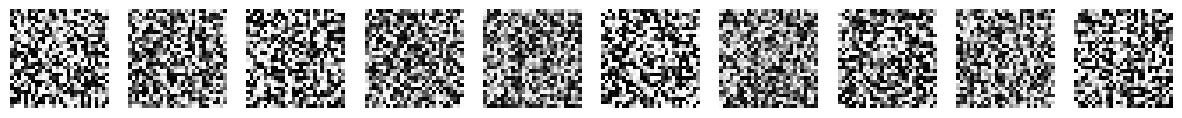

In [7]:
# Функция для отображения сгенерированных изображений
def display_generated_images(generator, num_images=10):
    noise = np.random.normal(0, 1, (num_images, 100))
    generated_images = generator.predict(noise)

    # Нормализация изображений в диапазон [0, 1] для отображения
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

# Вызов функции для отображения результатов
display_generated_images(generator)


In [9]:
# Функция для оценки точности дискриминатора и генератора
def evaluate_models(generator, discriminator, num_samples=1000):
    # Генерация случайного шума для создания поддельных изображений
    noise = np.random.normal(0, 1, (num_samples, 100))
    fake_images = generator.predict(noise)
    fake_labels = np.zeros((num_samples, 1))

    # Генерация реальных изображений
    idx = np.random.randint(0, x_train.shape[0], num_samples)
    real_images = x_train[idx]
    real_labels = np.ones((num_samples, 1))

    # Оценка дискриминатора на реальных и поддельных изображениях
    real_loss, real_acc = discriminator.evaluate(real_images, real_labels, verbose=0)
    fake_loss, fake_acc = discriminator.evaluate(fake_images, fake_labels, verbose=0)

    # Вывод результатов
    print(f"Точность дискриминатора на реальных изображениях: {real_acc:.2f}")
    print(f"Точность дискриминатора на поддельных изображениях: {fake_acc:.2f}")
    print(f"Средняя потеря дискриминатора: {(real_loss + fake_loss) / 2:.4f}")

    # Генерация случайного шума для проверки генератора
    noise = np.random.normal(0, 1, (num_samples, 100))
    valid_y = np.ones((num_samples, 1))
    g_loss = gan.evaluate(noise, valid_y, verbose=0)

# Вызов функции для оценки
evaluate_models(generator, discriminator)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Точность дискриминатора на реальных изображениях: 0.97
Точность дискриминатора на поддельных изображениях: 0.00
Средняя потеря дискриминатора: 4.5231
